<a href="https://colab.research.google.com/github/sandhyaparna/NLP/blob/main/Dell_Take_Home.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# import Libraries
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
from google.colab import files
import json
import seaborn as sns
import matplotlib.pyplot as plt
import string, re, os
import collections
from collections import defaultdict, Counter, OrderedDict

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
more_stopwords = ['i']
stop_words = stop_words + more_stopwords

import spacy
nlp = spacy.load('en', parse = False, tag=False, entity=False)

from wordcloud import WordCloud
import textblob
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, KFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, classification_report
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)

In [3]:
print("upload boston_bombing_tweets - Home test Data Scientist.csv file")
tweets_uploaded = files.upload()

upload boston_bombing_tweets - Home test Data Scientist.csv file


Saving boston_bombing_tweets - Home test Data Scientist.csv to boston_bombing_tweets - Home test Data Scientist.csv


In [4]:
print("upload replacements_dict.json file")
dict_uploaded = files.upload()

upload replacements_dict.json file


Saving replacements_dict.json to replacements_dict.json


In [5]:
import io
boston_bombing_tweets = pd.read_csv(io.BytesIO(tweets_uploaded['boston_bombing_tweets - Home test Data Scientist.csv']))
print(f'Tweets data is loaded')

tweets_train = boston_bombing_tweets[pd.notnull(boston_bombing_tweets.label)]
print("Number of observations in train data are", tweets_train.shape[0])

tweets_test = boston_bombing_tweets[pd.isnull(boston_bombing_tweets.label)]
print("Number of observations in test data are", tweets_test.shape[0])

Tweets data is loaded
Number of observations in train data are 4000
Number of observations in test data are 12218


In [6]:
with open('replacements_dict.json') as json_file:
  replacements_dict = json_file.readlines()
  
replacements_dict = map(lambda x: x.rstrip(), replacements_dict)
replacements_dict = ' '.join(replacements_dict)
replacements_dict = json.loads(replacements_dict, object_pairs_hook=OrderedDict)
print("replacements dictionary is loaded")

replacements dictionary is loaded


In [7]:
# helper functions
def replace_all(text, dic=replacements_dict):
    for i, j in dic.items():
        text = re.sub(i, j, text)
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text
    
def text_preprocess(text):
  text = re.sub('[%s]' % re.escape(string.punctuation.replace('#','')), '', text)
  text = re.sub('^# |# ', '', text)
  text = re.sub('[^\u0000-\u007e]+', '', text)
  text = ' '.join(word for word in text.split(' ') if word not in stop_words)
  return text

def create_corpus(data, text_var, condition):
    corpus=[]
    
    if condition == "hash":
      for x in data['text_processed'].apply(lambda x: re.findall(r'(?<=)#\w+',x)):
          for i in x:
            corpus.append(i)
    
    else:  # non-hash words
      for x in data['text_processed'].apply(lambda x: re.findall(r'(?#)\w+',x)):
        for i in x:
          corpus.append(i)

    return corpus

def get_top_tweet_ngrams(corpus, n):
    vec = CountVectorizer(ngram_range=(n, n), token_pattern=r'\b\w\w+\b|(?<!\w)#\w+').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:None]

In [8]:
# pre-processing function
def preprocessing_fn(data, text_var):
  """
  delete missing values, 

  """
  data = data[pd.notnull(data[text_var])]
  data[text_var+'_processed'] = data[text_var].str.lower()
  data[text_var+'_URL_present'] = np.where(data[text_var+'_processed'].str.contains("http://"),1,0)
  data[text_var+'_retweet'] = np.where(data[text_var+'_processed'].str.contains("rt @"),1, 0)

  data[text_var+'_processed'] = data[text_var+'_processed'].apply(lambda x: replace_all(x,replacements_dict))
  data[text_var+'_punctuations_count'] = data[text_var+'_processed'].apply(lambda x: re.findall('[%s]' % re.escape(string.punctuation),str(x))).str.len() 
  data[text_var+'_word_count'] = data[text_var+'_processed'].apply(lambda x: len(str(x).split()))
  data[text_var+'_hashtag_count'] = data[text_var+'_processed'].apply(lambda x: len([c for c in str(x) if c == '#']))
  
  data[text_var+'_processed'] = data[text_var+'_processed'].apply(lambda x: lemmatize_text(x))
  data[text_var+'_processed'] = data[text_var+'_processed'].apply(lambda x: text_preprocess(x))

  return data

### Baseline Model

In [41]:
# feature engineering of n-grams
def feature_engineering(data):
  features = []

  for i, j in Counter(create_corpus(data, "text_processed", "non-hash")).items():
    if j > 30:
      features.append(i)

  for i, j in Counter(create_corpus(data, "text_processed", "hash")).items():
    if j > 10:
      features.append(i)

  for i, j in get_top_tweet_ngrams(data["text_processed"], 2):
    if j > 10:
      features.append(i)

  for i, j in get_top_tweet_ngrams(data["text_processed"], 3):
    if j > 5:
      features.append(i)

  print(features)
  print(len(features))

  for i in features:
    data[i] = np.where(data["text_processed"].str.contains(i),1,0)  # data[i+"_ngram"]
  
  # data.columns = data.columns.str.replace(' ', '_')
  
  return data

In [42]:
tweets_train_processed = feature_engineering(preprocessing_fn(tweets_train, "text"))
# train = tweets_train_processed.drop(['text', 'text_processed'],axis=1)
# train.head()

['report', 'suspect', 'custody', 'man', 'terrorist', 'still', 'boat', 'dzhokhar', 'tsarnaev', 'terror', 'president', 'street', 'watertown', 'boston', 'old', 'day', 'one', 'win', 'look', 'job', 'cambridge', 'bomb', 'attack', 'let', 'us', 'make', 'great', 'thing', 'like', 'bostonstrong', 'never', 'find', 'give', 'heart', 'get', 'time', 'want', 'dead', 'marathon', 'bombing', 'start', 'prayforboston', 'happen', 'prayer', 'go', 'family', 'come', 'tonight', 'back', 'good', 'first', 'place', 'new', 'run', 'event', 'even', 'police', 'everyone', 'today', 'city', 'home', 'life', 'tamerlan', 'via', 'pray', 'world', 'bostonmarathon', 'service', 'assistant', 'area', 'week', 'work', 'software', 'manager', 'two', 'see', 'team', 'help', 'w', 'friend', 'update', 'manhunt', 'think', 'would', 'l', 'celtic', 'ticket', 'snow', 'tomorrow', 'year', 'love', 'high', 'full', 'right', 'talk', 'use', 'house', 'know', 'victim', 'please', 'many', 'take', 'live', 'redsox', 'official', 'say', 'brother', 'game', 'engi

,label,text_URL_present,text_retweet,text_punctuations_count,text_word_count,text_hashtag_count,report,suspect,custody,man,terrorist,still,boat,dzhokhar,tsarnaev,terror,president,street,watertown,boston,old,day,one,win,look,job,cambridge,bomb,attack,let,us,make,great,thing,like,bostonstrong,never,find,give,heart,get,time,want,dead,marathon,bombing,start,prayforboston,happen,prayer,go,family,come,tonight,back,good,first,place,new,run,event,even,police,everyone,today,city,home,life,tamerlan,via,pray,world,bostonmarathon,service,assistant,area,week,work,software,manager,two,see,team,help,w,friend,update,manhunt,think,would,l,celtic,ticket,snow,tomorrow,year,love,high,full,right,talk,use,house,know,victim,please,many,take,live,redsox,official,say,brother,game,engineer,news,scene,believe,end,fbi,hope,mass,senior,morning,tell,tragedy,stop,guy,school,open,feel,show,big,massachusetts,anyone,law,sale,bos,seek,next,capture,really,people,stay,could,last,hour,thank,community,bruin,st,college,may,student,photo,officer,way,rt,need,night,call,break,part,kill,arrest,watch,fire,monday,video,nba,celtics,support,red,state,search,hire,join,well,business,keep,scanner,hear,move,much,post,boston job,dzhokhar tsarnaev,job boston,boston marathon,bos boston,boston celtics,marathon attack,bombing suspect,boston news,year old,tamerlan tsarnaev,boston police,suspect custody,suspect dzhokhar,marathon bombing,news boston,boston boston,cambridge job,boston prayforboston,let us,part time,terrorist attack,boston area,manager boston,terror attack,watertown manhunt,come boston,bostonmarathon prayforboston,bomb suspect,watertown boston,manhunt watertown,marathon terror,law enforcement,terror bombing,red sox,go boston,boston watertown,boston bombing,boston redsox,boston common,full time,bostonstrong prayforboston,break news,back boston,prayforboston bostonstrong,attack boston,prayer go,tsarnaev cambridge,police officer,thought prayer,boston college,state police,day boston,boston bomb,boston terror,software engineer,city boston,hunt search,search terror,terror justice,justice win,join us,look like,job cambridge,prayforboston bostonmarathon,tsarnaev brother,boston attack,last night,boston red,capture hunt,dzhokar tsarnaev,today prayforboston,boston bruins,boston bruin,new bedford,bombing investigation,bostonmarathon attack,win suspect,prayforboston prayfortexas,despite report,report contrary,contrary arrest,arrest marathon,scene watertown,boston get,boston senior,boston globe,part boston,boat watertown,nba boston,live boston,love boston,people boston,hour full,tsarnaev custody,street watertown,heart attack,watertown suspect,job senior,feel like,source tell,bruin nhl,take custody,custody new,bedford part,today boston,boston university,act terror,suspect identify,watertown bostonstrong,boston today,prayfortexas prayforboston,boston bostonstrong,time boston,boston tonight,cambridge mass,people take,heart go,aero bu,prayforboston boston,happen boston,boston one,bostonstrong watertown,south boston,suspect dzhokhar tsarnaev,boston marathon terror,boston marathon bombing,dzhokhar tsarnaev cambridge,hunt search terror,search terror justice,terror justice win,marathon terror bombing,boston red sox,capture hunt search,boston terror attack,justice win suspect,win suspect custody,despite report contrary,report contrary arrest,contrary arrest marathon,arrest marathon attack,boston bombing suspect,boston marathon attack,take custody new,custody new bedford,new bedford part,bedford part boston,part boston marathon,terror bombing investigation,boston bomb suspect,hour full time,marathon bombing suspect,people take custody,bombing suspect dzhokhar,tsarnaev cambridge mass,identify dzhokhar tsarnaev,massachusetts news boston,manager boston job,dzhokhar tsarnaev custody,three people take,survive boston bomb,bomb suspect identify,suspect identify dzhokhar,watertown bpd scanner,full time salary,mit police officer,nba boston celtics,boston bostonmarathon prayforboston,job boston senior,bo

In [76]:
# model building
def build_model(data):
  
  data = data.drop(['text', 'text_processed'],axis=1)

  # split data into 80% Train & 20% Test - Stratified split
  X = data.drop(['label'],axis=1)
  y = data[['label']]
  X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.20, random_state=42)
  
  cv = KFold(n_splits=10, random_state=1, shuffle=True)
  # create model
  nb = MultinomialNB()
  # evaluate model
  scores = cross_val_score(nb, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
  # report performance
  print('Cross Validation Accuracy Score: %.3f (%.3f)\n' % (np.mean(scores), np.std(scores)))

  # train the model
  nb.fit(X_train, y_train)

  # make class and probability predictions
  y_pred_class = nb.predict(X_eval)
  y_pred_prob = nb.predict_proba(X_eval)[:, 1]

  print("Performance evaluation of the Naive Bayes model")

  print("Confusion Matrix","\n",pd.crosstab(y_eval.label, y_pred_class, rownames=['True'], colnames=['Predicted'], margins=True))

  print("\n","Classification Report","\n",classification_report(y_eval, y_pred_class))

  fpr, tpr, thresholds = roc_curve(y_eval, y_pred_prob)
  # create plot
  plt.plot(fpr, tpr, label='ROC curve'+', AUC='+str(round(roc_auc_score(y_eval, y_pred_prob).mean(),3)))
  plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
  _ = plt.xlabel('False Positive Rate')
  _ = plt.ylabel('True Positive Rate')
  _ = plt.title('ROC Curve')
  _ = plt.xlim([-0.02, 1])
  _ = plt.ylim([0, 1.02])
  _ = plt.legend(loc="lower right")

  return plt

Cross Validation Accuracy Score: 0.975 (0.007)

Performance evaluation of the Naive Bayes model
Confusion Matrix 
 Predicted  0.0  1.0  All
True                    
0.0        392  11   403
1.0        0    397  397
All        392  408  800

 Classification Report 
               precision    recall  f1-score   support

         0.0       1.00      0.97      0.99       403
         1.0       0.97      1.00      0.99       397

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

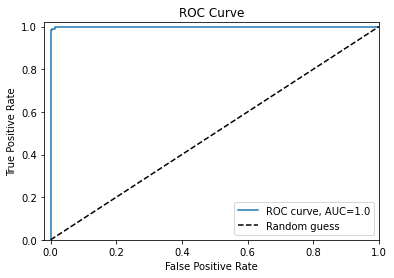

In [77]:
build_model(tweets_train_processed)

### Model with only important features

In [ ]:
# Extract important features
imps = permutation_importance(nb, X_eval, y_eval)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

independent_cols = list(X_eval)
important_features_ngrams = []
for f in range(X_eval.shape[1]):
  if importances[indices[f]] > 0: 
    important_features_ngrams.append(independent_cols[indices[f]])

len(important_features_ngrams)
important_features_ngrams[:5]

with open('important_features_ngrams.txt', 'w') as filehandle:
    for feature in important_features_ngrams:
        filehandle.write('%s\n' % feature)

In [78]:
print("upload important_features_ngrams.txt file")
imp_features_uploaded = files.upload()

upload important_features_ngrams.txt file


Saving important_features_ngrams.txt to important_features_ngrams (1).txt


In [80]:
# define an empty list
important_features_ngrams = []

# open file and read the content in a list
with open('important_features_ngrams.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        feature = line[:-1]
        # add item to the list
        important_features_ngrams.append(feature)

In [ ]:
# imp = []
# for i in important_features:
#   i = i.replace("_ngram", "")
#   i = i.replace("_", " ")
#   imp.append(i)
# imp

In [58]:
def feature_engineering_imp(data, important_features):

  for i in important_features:
    data[i] = np.where(data["text_processed"].str.contains(i),1,0)
  
  return data

In [ ]:
tweets_train_processed_imp_features = feature_engineering_imp(preprocessing_fn(tweets_train, "text"), important_features_ngrams)
tweets_train_processed_imp_features.head()

Cross Validation Accuracy Score: 0.987 (0.006)

Performance evaluation of the Naive Bayes model
Confusion Matrix 
 Predicted  0.0  1.0  All
True                    
0.0        397  6    403
1.0        0    397  397
All        397  403  800

 Classification Report 
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       403
         1.0       0.99      1.00      0.99       397

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

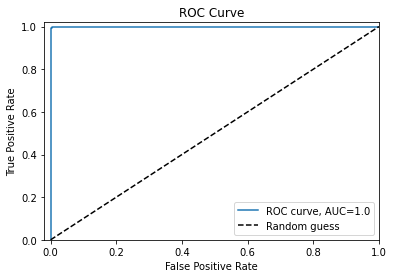

In [85]:
build_model(tweets_train_processed_imp_features)

### TF-IDF

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
TFIDFNGrams_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=100)
X = TFIDFNGrams_vectorizer.fit_transform(tweets_train_processed.text_processed.values)
TextDf_TFIDFNGramsVectors = pd.DataFrame(X.A, columns=TFIDFNGrams_vectorizer.get_feature_names())
print(TextDf_TFIDFNGramsVectors.shape)
TextDf_TFIDFNGramsVectors.head()

(4000, 100)


,area,arrest,attack,back,boat,bomb,bombing,bos,bos boston,boston,boston celtics,boston job,boston marathon,bostonmarathon,bostonstrong,break,bruin,call,cambridge,celtics,city,come,custody,day,dzhokhar,dzhokhar tsarnaev,engineer,everyone,family,fbi,find,friend,get,go,good,great,guy,help,home,hour,job,job boston,kill,know,let,like,live,look,love,make,man,manager,manhunt,marathon,nba,need,new,news,night,officer,old,one,part,people,police,prayer,prayforboston,report,right,run,sale,say,scene,see,service,show,still,street,suspect,take,tamerlan,team,terror,terrorist,thank,think,time,today,tonight,tsarnaev,us,via,victim,want,watertown,week,win,work,would,year
0,0.0,0.0,0.0,0.0,0.334782,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.332933,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.3471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.635083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.336683,0.000000,0.255429,0.0,0.0,0.0,0.000000,0.273256,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.546084,0.000000,0.421316,0.443428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.418959,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.39004,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.117617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.375499,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.421779,0.363189,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.424607,0.000000,0.0,0.0,0.0,0.335595,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.24425,0.0,0.427538,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.294255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.955727,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0


In [32]:
TextDf_TFIDFNGramsVectors_test = TFIDFNGrams_vectorizer.transform(tweets_test.text.values)

(12218, 100)